In [69]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(123456)

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
v0_data_dir = '../data/test_files_v0'
# v12_data_dir = '../data/test_files_v12'


# Replace the path with your own. 
filenames_v0 = next(walk(v0_data_dir), (None, None, []))[2] 
# filenames_v12 = next(walk(v12_data_dir), (None, None, []))[2] 


categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
        categories[label] = 0
    categories[label] += 1 

# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label not in categories.keys() : 
#         categories[label] = 0
#     categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
    print(x , y)




==> All data : 

test order dependency 103
randomness 17
time 42
network 31
platform dependency 2
resource leak 10
async wait 125
test case timeout 14
concurrency 48
unordered collections 51
floating point operations 3
too restrictive range 3
i_o 2


In [72]:
from sklearn.model_selection import train_test_split
buggy_code = []
filenames = []

for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label == 'async wait':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'unordered collections':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'concurrency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'time':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)
    elif label == 'test order dependency':
        with open(f'../data/test_files_v0/{file}', 'r') as buggy_file:
            buggy_code.append(buggy_file.read())
            filenames.append(file)

        
# for file in filenames_v12:
#     label = (file.split("@")[1]).split('.')[0].strip().lower() 
#     if label == 'async wait':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'unordered collections':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'concurrency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'time':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)
#     elif label == 'test order dependency':
#         with open(f'../data/test_files_v12/{file}', 'r') as buggy_file:
#             buggy_code.append(buggy_file.read())
#             filenames.append(file)

        
train_buggy_code, valid_buggy_code = train_test_split(buggy_code, test_size=0.2, random_state=42)
train_filenames, valid_filenames = train_test_split(filenames,test_size=0.2,random_state=42)

In [73]:
label_to_int= {
    'async wait': 0,
    'unordered collections': 1,
    'concurrency': 2,
    'time': 3,
    'test order dependency': 4
}

In [74]:
from torch.utils.data import Dataset
import numpy as np
import random
m_len = 3402
class SiameseDataset(Dataset):
    def __init__(self, buggy_code, tokenizer, codebert, filenames, split):
        self.buggy_code = buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.filenames = filenames
        self.split = split
        self.max_len = 0
        
        # Preprocess filenames to map labels to indices
        self.label_to_indices = {}
        for index, filename in enumerate(filenames):
            label = self._extract_label(filename)
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(index)

        # For negative sampling
        self.labels = [self._extract_label(filename) for filename in filenames]
        self.unique_labels = list(set(self.labels))

    def __len__(self):
        return len(self.buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self._extract_label(self.filenames[idx])

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])


            anchor = self._process_snippet(self.buggy_code[idx])
            positive = self._process_snippet(self.buggy_code[positive_idx])
            negative = self._process_snippet(self.buggy_code[negative_idx])
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False

            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'positive': torch.nn.functional.pad(positive, (0, m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, m_len - negative.size(0))),
                'label': anchor_label,  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split =='val':
            anchor_label = self._extract_label(self.filenames[idx])
            anchor = self._process_snippet(self.buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, m_len - anchor.size(0))),
                'label': anchor_label  # Optional, depends on how you want to use it
            }
        
    def _extract_label(self, filename):
        # Implement logic to extract label from filename
        return label_to_int[(filename.split("@")[1]).split('.')[0].strip().lower()]

    def _process_snippet(self, snippet):
        import torch

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:

            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:

            total_length = inputs['input_ids'].shape[1]
            # if total_length >= self.max_len:
            #     self.max_len = total_length
            #     print(self.max_len)
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

                # del input_segment, output_segment, cls_segment  # Free up memory
                # torch.cuda.empty_cache()  # Clear cache
                # gc.collect()  # Invoke garbage collector

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts


        
        # #CHECKING WHAT HAPPENS WHEN WE REMOVE MAX LENGTH CONSTRAINT
        # inputs = self.tokenizer(snippet, return_tensors='pt').to(device)
        # #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
        # print(inputs['input_ids'].shape[1])
        # if((inputs['input_ids'].shape[1])<512):
        #     with torch.no_grad():
        #         outs = self.codebert(**inputs)
        #     cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        #     return cls
        # else:
        #     print('longtest')
        #     i = 0
        #     part_vector =  []
        #     while ( i < (inputs['input_ids'].shape[1])-200) :
        #         print('in while')
        #         #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
        #         #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
        #         input_seg = [self.tokenizer.cls_token] + inputs['input_ids'][1][i:i+250] +[self.tokenizer.sep_token]
        #         with torch.no_grad():
        #             ots = self.codebert(**input_seg)
        #         cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
        #         #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
        #         #vector = cls[0].detach().numpy()
        #         parts.append(cls)
        #         i = i+100
        #     return parts
            
            

In [75]:

# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, tokenizer, model_codebert, train_filenames, 'train')
val_dataset = SiameseDataset(valid_buggy_code, tokenizer, model_codebert, valid_filenames, 'val')


# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [76]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [77]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 295/295 [00:11<00:00, 25.71it/s]


In [78]:

# Assuming plot_data is a list of 1D tensors of different lengths
max_length = max(tensor.size(0) for tensor in plot_data)
padded_data = [torch.nn.functional.pad(tensor, (0, max_length - tensor.size(0))) for tensor in plot_data]

In [79]:
max_length

3402

In [80]:
from collections import Counter

# Assuming 'train_dataloader' yields batches of data with 'label' key
class_counts = Counter()
for batch in train_dataloader:
    class_counts.update(batch['label'].cpu().numpy())

total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Convert to tensor and normalize
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float32).to(device)
class_weights_tensor = class_weights_tensor / class_weights_tensor.max()


In [81]:
class_counts

Counter({0: 101, 4: 79, 1: 44, 2: 37, 3: 34})

In [82]:
class_weights_tensor

tensor([0.3366, 0.7727, 0.9189, 1.0000, 0.4304], device='cuda:0')

In [83]:
colors = ['#CC1D1F', '#1DCC28', '#1D37CC', '#CC9D1D', '#BA1DCC']  # Red, Green, Blue, Yellow, Purple
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


In [84]:
# !python3 -m pip install matplotlib==3.5.2

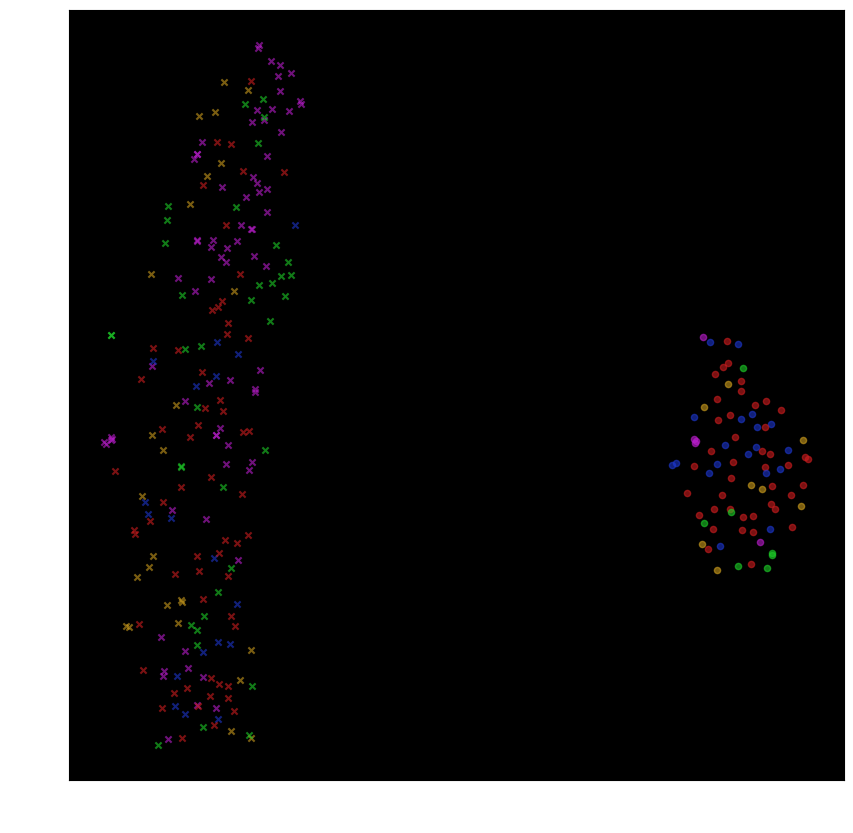

In [85]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# Set the background color to black
plt.gca().set_facecolor('black')
# Adjust the color of the ticks and labels for better visibility
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Component 1', color='white')
plt.ylabel('Component 2', color='white')

plt.show()


In [86]:
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch
# from sklearn.preprocessing import MinMaxScaler

# X = torch.stack(plot_data).cpu().numpy()
# labelsNums = plot_labels

# # Perform t-SNE dimensionality reduction
# X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# # Normalize the points
# scaler = MinMaxScaler()
# X_embedded_normalized = scaler.fit_transform(X_embedded)

# # Create the scatter plot
# plt.figure(figsize=(10, 10))
# for i in range(len(X_embedded_normalized)):
#     marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
#     plt.scatter(X_embedded_normalized[i, 0], X_embedded_normalized[i, 1], color=colors_array[i], s=20, alpha=0.6, marker=marker)

# # Set the background color to black
# plt.gca().set_facecolor('black')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')

# plt.show()


In [87]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [88]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, labels):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedTripletLoss(nn.Module):
    def __init__(self, margin=1.0, class_weights=None):
        super(WeightedTripletLoss, self).__init__()
        self.margin = margin
        self.class_weights = class_weights if class_weights is not None else torch.ones(1).to(device)

    def forward(self, anchor, positive, negative, labels):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        # Apply class-specific weights
        if self.class_weights is not None:
            labels = labels.to(self.class_weights.device)
            weights = self.class_weights[labels]
            losses = losses * weights

        return losses.mean()

In [90]:
#class_weights = torch.tensor([1.0, 1.0, 1.5, 1.5, 1.0])
learning_rate = 5e-6
num_epochs = 200
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = WeightedTripletLoss(margin=1.0, class_weights=class_weights_tensor)
#criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)

#triplet_loss = WeightedTripletLoss(margin=1.0, class_weights=class_weights)

In [91]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [92]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
best_loss = 100.0
num_epochs = 200
writer = SummaryWriter('logs/flakyXbert++_369dp_difflr')
epoch_loss_list = []

for epoch in range(num_epochs + 100):
    total_loss = 0
    siamese_network.train()
    
    for i, batch in enumerate(tqdm(train_dataloader)):
        labels = batch['label'].to(device)
        batch_anchor = batch['anchor'].to(device)
        batch_positive = batch['positive'].to(device)
        batch_negative = batch['negative'].to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        
        if total_loss <= best_loss:
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert++_369dp_difflr.pth')
            best_loss = total_loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")

criterion = TripletLoss(margin=1.0)
for epoch in range(num_epochs):
    total_loss = 0
    siamese_network.train()
    
    for i, batch in enumerate(tqdm(train_dataloader)):
        labels = batch['label'].to(device)
        batch_anchor = batch['anchor'].to(device)
        batch_positive = batch['positive'].to(device)
        batch_negative = batch['negative'].to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_dataloader) + i)
        total_loss += loss.item()
        
        if total_loss <= best_loss:
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), 'flakyXbert++_369dp_difflr.pth')
            best_loss = total_loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")


  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:16,  2.15it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 1/200, Loss: 0.8659250107971398


  3%|▎         | 1/37 [00:00<00:14,  2.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 2/200, Loss: 0.5392862888606819


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 3/200, Loss: 0.5283709599359615


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 4/200, Loss: 0.5353233870622274


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 5/200, Loss: 0.5363826203990627


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 6/200, Loss: 0.5493951427775461


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 7/200, Loss: 0.5082642548793072


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 8/200, Loss: 0.5368049040034011


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 9/200, Loss: 0.5407277369821394


  3%|▎         | 1/37 [00:00<00:10,  3.55it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 10/200, Loss: 0.5019920585123269


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 11/200, Loss: 0.5206056333876945


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 12/200, Loss: 0.4985045710125485


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 13/200, Loss: 0.4981706726389962


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 14/200, Loss: 0.47815109910191717


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 15/200, Loss: 0.546022005177833


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 16/200, Loss: 0.5211692822946085


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 17/200, Loss: 0.5298031906823855


  3%|▎         | 1/37 [00:00<00:11,  3.20it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 18/200, Loss: 0.490977093980119


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 19/200, Loss: 0.5106851305510547


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 20/200, Loss: 0.509462758496001


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 21/200, Loss: 0.4883238604745349


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 22/200, Loss: 0.5101558956745509


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 23/200, Loss: 0.4873731265196929


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 24/200, Loss: 0.4870265931696505


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 25/200, Loss: 0.48272396664361694


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 26/200, Loss: 0.4785394245708311


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 27/200, Loss: 0.44870373526135005


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 28/200, Loss: 0.4988285484346184


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 29/200, Loss: 0.42744642093374924


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 30/200, Loss: 0.4079319272895117


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 31/200, Loss: 0.48580352116275477


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 32/200, Loss: 0.43155615071992615


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 33/200, Loss: 0.42170530315991994


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 34/200, Loss: 0.4345555949855495


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 35/200, Loss: 0.44321794928731145


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 36/200, Loss: 0.4003720128455678


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 37/200, Loss: 0.40481135692145376


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 38/200, Loss: 0.4245662318693625


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 39/200, Loss: 0.36249501076904506


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 40/200, Loss: 0.39147836775393097


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 41/200, Loss: 0.4224309965565398


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 42/200, Loss: 0.3945535262291496


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 43/200, Loss: 0.42048480261016535


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 44/200, Loss: 0.36493863930573334


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 45/200, Loss: 0.3683410178165178


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 46/200, Loss: 0.37386024823865377


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 47/200, Loss: 0.37947445523899953


100%|██████████| 37/37 [00:11<00:00,  3.33it/s]


Epoch 48/200, Loss: 0.3435079548004511


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 49/200, Loss: 0.3564275777017748


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 50/200, Loss: 0.3624192939416782


  3%|▎         | 1/37 [00:00<00:12,  2.93it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 51/200, Loss: 0.34420721333574605


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 52/200, Loss: 0.3474546616544595


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 53/200, Loss: 0.33978025212481217


  3%|▎         | 1/37 [00:00<00:12,  2.78it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 54/200, Loss: 0.34891397808049174


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 55/200, Loss: 0.33598714493013715


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 56/200, Loss: 0.33722825187283595


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 57/200, Loss: 0.3087488978698447


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 58/200, Loss: 0.3366090584848378


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 59/200, Loss: 0.3037148879186527


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 60/200, Loss: 0.30558557788262497


  3%|▎         | 1/37 [00:00<00:14,  2.53it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 61/200, Loss: 0.29424896705392245


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 62/200, Loss: 0.27931469235871287


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 63/200, Loss: 0.29342494824448145


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 64/200, Loss: 0.23957895004266017


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 65/200, Loss: 0.28851582371705287


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 66/200, Loss: 0.26887341265289766


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 67/200, Loss: 0.27621088942160477


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 68/200, Loss: 0.27711434886362907


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 69/200, Loss: 0.31662708369864


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 70/200, Loss: 0.283905803754523


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 71/200, Loss: 0.25705407267889463


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 72/200, Loss: 0.2790828923115859


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 73/200, Loss: 0.2668964035204939


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 74/200, Loss: 0.22696686636757207


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 75/200, Loss: 0.26511370924276273


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 76/200, Loss: 0.20366508514947584


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 77/200, Loss: 0.337589499112722


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 78/200, Loss: 0.252492139871056


  3%|▎         | 1/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 79/200, Loss: 0.23413682970646266


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 80/200, Loss: 0.2153433667042771


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 81/200, Loss: 0.2446401907710006


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 82/200, Loss: 0.232368437724339


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 83/200, Loss: 0.275519285552405


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 84/200, Loss: 0.2634143410502253


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 85/200, Loss: 0.18656529496247704


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 86/200, Loss: 0.22256928048021085


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 87/200, Loss: 0.19726690358004054


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 88/200, Loss: 0.20276939469968547


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 89/200, Loss: 0.1885487104489191


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 90/200, Loss: 0.18759911295932694


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 91/200, Loss: 0.1810292012586787


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 92/200, Loss: 0.1635658314099183


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 93/200, Loss: 0.20669952795110844


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 94/200, Loss: 0.22842581831925624


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 95/200, Loss: 0.23375865323720751


  3%|▎         | 1/37 [00:00<00:11,  3.18it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 96/200, Loss: 0.21159187007091335


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 97/200, Loss: 0.20159353889726303


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 98/200, Loss: 0.1694596902140089


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 99/200, Loss: 0.18745494735225834


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 100/200, Loss: 0.1877053418775668


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 101/200, Loss: 0.20055455359554775


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 102/200, Loss: 0.18914455799637614


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 103/200, Loss: 0.21362052676645485


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 104/200, Loss: 0.2173395152329593


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 105/200, Loss: 0.20551566125170603


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 106/200, Loss: 0.15610484617787437


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 107/200, Loss: 0.19629836577066295


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 108/200, Loss: 0.1863218427107141


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 109/200, Loss: 0.18499896302819252


  3%|▎         | 1/37 [00:00<00:14,  2.41it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 110/200, Loss: 0.17955923367392373


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 111/200, Loss: 0.18966664011413986


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 112/200, Loss: 0.14893996358119152


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 113/200, Loss: 0.1433286934814139


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 114/200, Loss: 0.1801259169304693


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 115/200, Loss: 0.1678072051019282


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 116/200, Loss: 0.17405484324774226


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 117/200, Loss: 0.17781563913072082


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 118/200, Loss: 0.17873123529795054


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 119/200, Loss: 0.1717905706247768


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 120/200, Loss: 0.183862110901926


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 121/200, Loss: 0.1680616453239644


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 122/200, Loss: 0.167560949021749


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 123/200, Loss: 0.165655260578402


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 124/200, Loss: 0.1334588241517997


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 125/200, Loss: 0.13535013246173794


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 126/200, Loss: 0.17335737521785335


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 127/200, Loss: 0.18065305889861002


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 128/200, Loss: 0.14075211402834267


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 129/200, Loss: 0.17751807249088242


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 130/200, Loss: 0.15086557523337998


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 131/200, Loss: 0.11390601904005618


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 132/200, Loss: 0.17491261117361687


100%|██████████| 37/37 [00:13<00:00,  2.71it/s]


Epoch 133/200, Loss: 0.15723308810108416


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 134/200, Loss: 0.11002993257087026


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 135/200, Loss: 0.14407654933480396


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 136/200, Loss: 0.21296698670532252


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 137/200, Loss: 0.16096542163978558


100%|██████████| 37/37 [00:13<00:00,  2.76it/s]


Epoch 138/200, Loss: 0.13061375996550997


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 139/200, Loss: 0.14724478610740924


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 140/200, Loss: 0.13241132032016065


  3%|▎         | 1/37 [00:00<00:14,  2.51it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 141/200, Loss: 0.14583068938825178


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 142/200, Loss: 0.13663614018996423


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 143/200, Loss: 0.1510780448396061


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 144/200, Loss: 0.11601492503305545


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 145/200, Loss: 0.12357936391757952


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 146/200, Loss: 0.16302483272109483


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 147/200, Loss: 0.15926447055126364


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 148/200, Loss: 0.132847154500416


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 149/200, Loss: 0.13060505038781747


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 150/200, Loss: 0.1455320530646556


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 151/200, Loss: 0.1356537608521034


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 152/200, Loss: 0.13404387970631187


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 153/200, Loss: 0.14592584464195613


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 154/200, Loss: 0.13335252427370162


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 155/200, Loss: 0.10862826917169464


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 156/200, Loss: 0.14082494082646696


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 157/200, Loss: 0.12662372903936114


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 158/200, Loss: 0.13535976882495387


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 159/200, Loss: 0.10977011708687437


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 160/200, Loss: 0.12455410613502199


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 161/200, Loss: 0.12896609360452843


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 162/200, Loss: 0.13242354208754525


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 163/200, Loss: 0.11601092877822954


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 164/200, Loss: 0.13007547099747369


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 165/200, Loss: 0.1352219174590868


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 166/200, Loss: 0.14840256749192957


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 167/200, Loss: 0.11591022548492293


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 168/200, Loss: 0.0949264221409386


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 169/200, Loss: 0.12476218527031911


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 170/200, Loss: 0.12077540292945765


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 171/200, Loss: 0.13889312354306615


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 172/200, Loss: 0.1279126994840398


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 173/200, Loss: 0.12057563744334353


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 174/200, Loss: 0.12888220168108977


100%|██████████| 37/37 [00:10<00:00,  3.37it/s]


Epoch 175/200, Loss: 0.11261481701119526


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 176/200, Loss: 0.12197769226229473


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 177/200, Loss: 0.1300334494963691


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 178/200, Loss: 0.09441813325660454


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 179/200, Loss: 0.11241926031338202


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 180/200, Loss: 0.11511746189884238


100%|██████████| 37/37 [00:10<00:00,  3.59it/s]


Epoch 181/200, Loss: 0.11282256445721597


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 182/200, Loss: 0.11929062774052492


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 183/200, Loss: 0.10872865815621775


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 184/200, Loss: 0.12946429406292737


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 185/200, Loss: 0.09600921615807188


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 186/200, Loss: 0.11907847455979602


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 187/200, Loss: 0.10634708751899165


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 188/200, Loss: 0.11379225948523428


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 189/200, Loss: 0.10612264546137806


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 190/200, Loss: 0.09530585528999516


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 191/200, Loss: 0.08238339063875075


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 192/200, Loss: 0.09760540995646168


  3%|▎         | 1/37 [00:00<00:15,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 193/200, Loss: 0.13403715791080045


  3%|▎         | 1/37 [00:00<00:08,  4.05it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.86it/s]


Epoch 194/200, Loss: 0.11933575223225194


  3%|▎         | 1/37 [00:00<00:13,  2.72it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 195/200, Loss: 0.10209451790748013


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 196/200, Loss: 0.0810694033280015


100%|██████████| 37/37 [00:11<00:00,  3.36it/s]


Epoch 197/200, Loss: 0.10155724654779644


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 198/200, Loss: 0.1189214775112231


  3%|▎         | 1/37 [00:00<00:11,  3.03it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 199/200, Loss: 0.10837823562984783


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 200/200, Loss: 0.10766798065899796


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 201/200, Loss: 0.10476163132242053


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 202/200, Loss: 0.11541045274950464


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 203/200, Loss: 0.1201849723788532


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 204/200, Loss: 0.0809301357917689


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 205/200, Loss: 0.08783902195707038


100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


Epoch 206/200, Loss: 0.07748309660048501


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 207/200, Loss: 0.10443611639375622


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 208/200, Loss: 0.09528154859671721


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 209/200, Loss: 0.10256771530760955


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 210/200, Loss: 0.13156204182352568


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 211/200, Loss: 0.0933054837624769


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 212/200, Loss: 0.09922121175741022


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 213/200, Loss: 0.09391662850661354


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 214/200, Loss: 0.08757391354585117


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 215/200, Loss: 0.1030896736900448


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 216/200, Loss: 0.10110179858433234


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 217/200, Loss: 0.09313040743959514


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 218/200, Loss: 0.10434920323156827


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 219/200, Loss: 0.10717456400822345


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 220/200, Loss: 0.12402077690018593


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 221/200, Loss: 0.11051530577242374


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 222/200, Loss: 0.10281074594555271


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 223/200, Loss: 0.06768346410496412


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 224/200, Loss: 0.09941925856007917


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 225/200, Loss: 0.0790987184548096


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 226/200, Loss: 0.10175232614730359


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 227/200, Loss: 0.06777702894917614


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 228/200, Loss: 0.0879186604020966


  3%|▎         | 1/37 [00:00<00:10,  3.29it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 229/200, Loss: 0.09514254429755178


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 230/200, Loss: 0.1344317151925753


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 231/200, Loss: 0.08903495582273684


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 232/200, Loss: 0.07093523855547647


100%|██████████| 37/37 [00:10<00:00,  3.43it/s]


Epoch 233/200, Loss: 0.08572676142904202


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 234/200, Loss: 0.07552252760207331


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 235/200, Loss: 0.056922278511715496


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 236/200, Loss: 0.07397674419287895


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 237/200, Loss: 0.048514888231718054


100%|██████████| 37/37 [00:13<00:00,  2.81it/s]


Epoch 238/200, Loss: 0.06617327651159989


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 239/200, Loss: 0.07956717477960361


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 240/200, Loss: 0.046032173156335544


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 241/200, Loss: 0.06833456757453245


  3%|▎         | 1/37 [00:00<00:13,  2.76it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 242/200, Loss: 0.07404493298570348


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 243/200, Loss: 0.08736335059527207


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 244/200, Loss: 0.08094224750970465


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 245/200, Loss: 0.06778584639038387


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 246/200, Loss: 0.06995630693445737


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 247/200, Loss: 0.059323202617265085


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 248/200, Loss: 0.09511288204482077


  3%|▎         | 1/37 [00:00<00:11,  3.02it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 249/200, Loss: 0.07813862266925138


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 250/200, Loss: 0.07083531744727814


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 251/200, Loss: 0.046289077808929456


  5%|▌         | 2/37 [00:00<00:08,  4.37it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 252/200, Loss: 0.0636096070268871


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 253/200, Loss: 0.09331657771474204


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 254/200, Loss: 0.0707360186639267


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 255/200, Loss: 0.08123959296357793


  3%|▎         | 1/37 [00:00<00:09,  3.67it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.97it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 256/200, Loss: 0.060774556474407784


  3%|▎         | 1/37 [00:00<00:10,  3.47it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.73it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 257/200, Loss: 0.0682495284473171


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 258/200, Loss: 0.09502589104797791


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 259/200, Loss: 0.06245576607604587


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 260/200, Loss: 0.07952835428452976


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 261/200, Loss: 0.0818922039494233


  3%|▎         | 1/37 [00:00<00:09,  3.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:19,  1.75it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 262/200, Loss: 0.058079147963105024


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 263/200, Loss: 0.07430398267870014


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 264/200, Loss: 0.06448739686527767


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 265/200, Loss: 0.060854211965626154


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 266/200, Loss: 0.06751250593948203


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 267/200, Loss: 0.08967087862106997


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 268/200, Loss: 0.07762661830496949


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 269/200, Loss: 0.06458543461269221


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 270/200, Loss: 0.06555203919147921


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 271/200, Loss: 0.08360830175838233


  3%|▎         | 1/37 [00:00<00:09,  3.85it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.49it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 272/200, Loss: 0.049192766017104324


  3%|▎         | 1/37 [00:00<00:21,  1.67it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 273/200, Loss: 0.06308828990252034


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 274/200, Loss: 0.10849998787523725


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 275/200, Loss: 0.06522836370041242


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 276/200, Loss: 0.0647557872297192


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 277/200, Loss: 0.0965300798061189


  3%|▎         | 1/37 [00:00<00:16,  2.16it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 278/200, Loss: 0.055668609594372476


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 279/200, Loss: 0.07886962361186994


100%|██████████| 37/37 [00:13<00:00,  2.77it/s]


Epoch 280/200, Loss: 0.05183356107099334


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 281/200, Loss: 0.06389058142195682


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 282/200, Loss: 0.06525405469929448


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 283/200, Loss: 0.08479103693939946


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 284/200, Loss: 0.060481035037318595


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 285/200, Loss: 0.07618733319277698


100%|██████████| 37/37 [00:11<00:00,  3.28it/s]


Epoch 286/200, Loss: 0.06566452456487192


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 287/200, Loss: 0.06242629389807179


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 288/200, Loss: 0.08894511393422412


  3%|▎         | 1/37 [00:00<00:15,  2.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 289/200, Loss: 0.05045251695539903


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 290/200, Loss: 0.05517397282292714


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 291/200, Loss: 0.04483485427320104


  3%|▎         | 1/37 [00:00<00:23,  1.54it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 292/200, Loss: 0.057672124406373176


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 293/200, Loss: 0.07624888036249054


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 294/200, Loss: 0.0683857614766001


  3%|▎         | 1/37 [00:00<00:10,  3.39it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 295/200, Loss: 0.06657479437873573


  3%|▎         | 1/37 [00:00<00:09,  3.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 296/200, Loss: 0.043299915950204174


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 297/200, Loss: 0.07874666477830426


  3%|▎         | 1/37 [00:00<00:06,  5.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.88it/s]


Epoch 298/200, Loss: 0.08247096327800504


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 299/200, Loss: 0.06594809953979142


  3%|▎         | 1/37 [00:00<00:07,  5.02it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  4.32it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 300/200, Loss: 0.05016110877732973


  3%|▎         | 1/37 [00:00<00:08,  4.01it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.31it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 1/200, Loss: 0.1266360454059936


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 2/200, Loss: 0.0880036188943966


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 3/200, Loss: 0.09129209151944599


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 4/200, Loss: 0.1365667307699049


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 5/200, Loss: 0.14428441750036702


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 6/200, Loss: 0.08379593813741529


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 7/200, Loss: 0.11694686613171487


100%|██████████| 37/37 [00:11<00:00,  3.20it/s]


Epoch 8/200, Loss: 0.20624809571214625


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 9/200, Loss: 0.08697966023071392


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 10/200, Loss: 0.13594488537794835


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 11/200, Loss: 0.12654554642535545


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 12/200, Loss: 0.11777882741109745


100%|██████████| 37/37 [00:12<00:00,  2.87it/s]


Epoch 13/200, Loss: 0.14883763443779302


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 14/200, Loss: 0.1509730497727523


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 15/200, Loss: 0.14474225648351619


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 16/200, Loss: 0.1169414310841947


100%|██████████| 37/37 [00:12<00:00,  2.89it/s]


Epoch 17/200, Loss: 0.14980042846621694


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 18/200, Loss: 0.14093421037132675


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 19/200, Loss: 0.13649032325358004


  3%|▎         | 1/37 [00:00<00:24,  1.46it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.34it/s]


Epoch 20/200, Loss: 0.09857509526852015


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 21/200, Loss: 0.09696573844632587


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 22/200, Loss: 0.08471087164975502


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 23/200, Loss: 0.10001044458634145


  3%|▎         | 1/37 [00:00<00:13,  2.61it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 24/200, Loss: 0.06626135855913162


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 25/200, Loss: 0.11751135901824848


  3%|▎         | 1/37 [00:00<00:12,  2.97it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 26/200, Loss: 0.07396563263358297


  3%|▎         | 1/37 [00:00<00:15,  2.35it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.73it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.82it/s]


Epoch 27/200, Loss: 0.09150500414339272


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 28/200, Loss: 0.08076817250332317


  3%|▎         | 1/37 [00:00<00:16,  2.23it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.53it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 29/200, Loss: 0.13294886918486776


  3%|▎         | 1/37 [00:00<00:17,  2.10it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.85it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 30/200, Loss: 0.06668665179529705


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 31/200, Loss: 0.08774388198916977


  3%|▎         | 1/37 [00:00<00:09,  3.74it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  2.93it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 32/200, Loss: 0.048239732010139


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 33/200, Loss: 0.07458586386732154


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 34/200, Loss: 0.10167710019929989


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 35/200, Loss: 0.07320122299967585


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 36/200, Loss: 0.08581834588501905


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 37/200, Loss: 0.15890690825275472


  3%|▎         | 1/37 [00:00<00:12,  2.84it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 38/200, Loss: 0.07439130605072589


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 39/200, Loss: 0.11587891143721503


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 40/200, Loss: 0.10888473216343571


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 41/200, Loss: 0.06727843187950752


  3%|▎         | 1/37 [00:00<00:17,  2.01it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.42it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 42/200, Loss: 0.09034601860755198


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 43/200, Loss: 0.07178935005858138


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 44/200, Loss: 0.06657016659910614


  3%|▎         | 1/37 [00:00<00:11,  3.08it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 45/200, Loss: 0.06645239748664804


  3%|▎         | 1/37 [00:00<00:14,  2.50it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.27it/s]


Epoch 46/200, Loss: 0.07075340059157964


  3%|▎         | 1/37 [00:00<00:25,  1.43it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:18,  1.93it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 47/200, Loss: 0.06540401461156639


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 48/200, Loss: 0.09523883904959704


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 49/200, Loss: 0.07379300026474772


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 50/200, Loss: 0.06498017202357988


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 51/200, Loss: 0.08288359420525061


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 52/200, Loss: 0.07838654981271641


  3%|▎         | 1/37 [00:00<00:11,  3.23it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.07it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.75it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 53/200, Loss: 0.0623914706143173


  3%|▎         | 1/37 [00:00<00:09,  3.91it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]


Epoch 54/200, Loss: 0.08591476606356131


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 55/200, Loss: 0.08400867617613561


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.78it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 56/200, Loss: 0.08562678884010057


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 57/200, Loss: 0.063213894898827


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 58/200, Loss: 0.0760868946845467


  3%|▎         | 1/37 [00:00<00:11,  3.07it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Epoch 59/200, Loss: 0.07379666131895941


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 60/200, Loss: 0.09824448199691


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 61/200, Loss: 0.08579612281676885


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 62/200, Loss: 0.09683703429795601


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 63/200, Loss: 0.1492929686162923


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 64/200, Loss: 0.07977605661427653


  3%|▎         | 1/37 [00:00<00:14,  2.51it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 65/200, Loss: 0.07079310050687275


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 66/200, Loss: 0.0473488571273314


  3%|▎         | 1/37 [00:00<00:09,  3.99it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.04it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.42it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.38it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.17it/s]


Epoch 67/200, Loss: 0.04426167764373728


  3%|▎         | 1/37 [00:00<00:05,  6.64it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.12it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 68/200, Loss: 0.047870229526951504


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 69/200, Loss: 0.07500844876709822


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 70/200, Loss: 0.07583150740813564


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 71/200, Loss: 0.07572449723611006


  3%|▎         | 1/37 [00:00<00:13,  2.66it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.50it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.91it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.65it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.46it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.61it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.75it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:03<00:10,  2.68it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 72/200, Loss: 0.06437576632644679


  3%|▎         | 1/37 [00:00<00:10,  3.35it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 73/200, Loss: 0.09218712614194767


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 74/200, Loss: 0.09609506621554091


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 75/200, Loss: 0.042043595826505006


  3%|▎         | 1/37 [00:00<00:09,  3.82it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.62it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.49it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.31it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 76/200, Loss: 0.06317396180049793


  3%|▎         | 1/37 [00:00<00:06,  5.71it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.15it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:10,  3.12it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.09it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.71it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:01<00:10,  3.03it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.15it/s]


Epoch 77/200, Loss: 0.06901376533347207


  3%|▎         | 1/37 [00:00<00:12,  2.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.30it/s]


Epoch 78/200, Loss: 0.07236513334351617


  3%|▎         | 1/37 [00:00<00:13,  2.77it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 79/200, Loss: 0.054488433575308


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 80/200, Loss: 0.04622626183806239


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 81/200, Loss: 0.03465854255734263


100%|██████████| 37/37 [00:12<00:00,  2.91it/s]


Epoch 82/200, Loss: 0.06776651347408423


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 83/200, Loss: 0.09443103723429344


  3%|▎         | 1/37 [00:00<00:12,  2.96it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.40it/s]


Epoch 84/200, Loss: 0.05274879288029026


  3%|▎         | 1/37 [00:00<00:14,  2.42it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.11it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.85it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.18it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:12,  2.51it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:12,  2.54it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:10,  2.82it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 85/200, Loss: 0.050925527472753786


  3%|▎         | 1/37 [00:00<00:10,  3.44it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.31it/s]


Epoch 86/200, Loss: 0.053609952733323384


100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Epoch 87/200, Loss: 0.058615504285773716


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 88/200, Loss: 0.07105165357525284


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 89/200, Loss: 0.06763419589480839


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 90/200, Loss: 0.0579909557426298


  3%|▎         | 1/37 [00:00<00:15,  2.39it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.40it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 91/200, Loss: 0.05265583379848583


  3%|▎         | 1/37 [00:00<00:13,  2.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 92/200, Loss: 0.04652089806827339


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 93/200, Loss: 0.0397140454198863


  3%|▎         | 1/37 [00:00<00:11,  3.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  2.03it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 94/200, Loss: 0.061507655357992325


  3%|▎         | 1/37 [00:00<00:10,  3.35it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:15,  2.32it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.96it/s]


Epoch 95/200, Loss: 0.028292011469602585


  3%|▎         | 1/37 [00:00<00:16,  2.19it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 96/200, Loss: 0.034012974919499575


100%|██████████| 37/37 [00:10<00:00,  3.38it/s]


Epoch 97/200, Loss: 0.06633411911693779


  3%|▎         | 1/37 [00:00<00:10,  3.39it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.23it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:11,  2.99it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:10,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 98/200, Loss: 0.04471346172126564


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 99/200, Loss: 0.047061334420750674


100%|██████████| 37/37 [00:11<00:00,  3.12it/s]


Epoch 100/200, Loss: 0.05266685381128981


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 101/200, Loss: 0.12440464182479961


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.97it/s]


Epoch 102/200, Loss: 0.09922210630532857


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 103/200, Loss: 0.0386348241889799


  3%|▎         | 1/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.05it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 104/200, Loss: 0.03727441059576499


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.37it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:12,  2.81it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.83it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:09,  3.23it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 105/200, Loss: 0.0538764201306008


  3%|▎         | 1/37 [00:00<00:11,  3.24it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.32it/s]


Epoch 106/200, Loss: 0.07044365196614652


  3%|▎         | 1/37 [00:00<00:09,  3.64it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.13it/s]


Epoch 107/200, Loss: 0.04489328042679542


  3%|▎         | 1/37 [00:00<00:10,  3.33it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.30it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.18it/s]


Epoch 108/200, Loss: 0.047084723574084206


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.04it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 109/200, Loss: 0.05230194269805341


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 110/200, Loss: 0.03293663726465122


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 111/200, Loss: 0.04731332433309306


  3%|▎         | 1/37 [00:00<00:10,  3.36it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:19,  1.84it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:15,  2.22it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.80it/s]


Epoch 112/200, Loss: 0.030137083014926395


  3%|▎         | 1/37 [00:00<00:15,  2.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.36it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 113/200, Loss: 0.03030332238287539


  3%|▎         | 1/37 [00:00<00:15,  2.25it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.55it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.00it/s]


Epoch 114/200, Loss: 0.08538099297800579


  3%|▎         | 1/37 [00:00<00:11,  3.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 115/200, Loss: 0.054340823276622874


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 116/200, Loss: 0.05023740030623771


100%|██████████| 37/37 [00:11<00:00,  3.16it/s]


Epoch 117/200, Loss: 0.05875524838228483


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 118/200, Loss: 0.041640669308804175


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.70it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.63it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.69it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.69it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 119/200, Loss: 0.06169491180697003


  3%|▎         | 1/37 [00:00<00:12,  2.90it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 120/200, Loss: 0.05366296663477614


  3%|▎         | 1/37 [00:00<00:13,  2.57it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.98it/s]


Epoch 121/200, Loss: 0.056222170692037894


  3%|▎         | 1/37 [00:00<00:14,  2.55it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.44it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 122/200, Loss: 0.03783554382420875


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 123/200, Loss: 0.09749927311330228


100%|██████████| 37/37 [00:11<00:00,  3.22it/s]


Epoch 124/200, Loss: 0.04826627349531328


  3%|▎         | 1/37 [00:00<00:18,  1.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.78it/s]


Epoch 125/200, Loss: 0.03989774803001735


  3%|▎         | 1/37 [00:00<00:19,  1.89it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:01<00:17,  1.95it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.07it/s]


Epoch 126/200, Loss: 0.06346328898861602


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 127/200, Loss: 0.017297954374068492


  0%|          | 0/37 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.71it/s]


Epoch 128/200, Loss: 0.07964133370567013


  3%|▎         | 1/37 [00:00<00:12,  2.88it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.60it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 129/200, Loss: 0.055114355643053316


100%|██████████| 37/37 [00:11<00:00,  3.25it/s]


Epoch 130/200, Loss: 0.05397891494873408


  3%|▎         | 1/37 [00:00<00:16,  2.12it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.55it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:13,  2.53it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 131/200, Loss: 0.03921366724613551


  3%|▎         | 1/37 [00:00<00:12,  2.86it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.00it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:11,  2.99it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.14it/s]


Epoch 132/200, Loss: 0.043367053608636595


  3%|▎         | 1/37 [00:00<00:14,  2.45it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.08it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.34it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.26it/s]


Epoch 133/200, Loss: 0.04685270383551314


  5%|▌         | 2/37 [00:00<00:07,  4.79it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.95it/s]


Epoch 134/200, Loss: 0.04208372734688424


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 135/200, Loss: 0.02710694940509023


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 136/200, Loss: 0.07203553173993085


  3%|▎         | 1/37 [00:00<00:17,  2.05it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:14,  2.37it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.64it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.82it/s]

Loss improved saving model
Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:09,  3.24it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.05it/s]

Loss improved saving model


 22%|██▏       | 8/37 [00:02<00:08,  3.29it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:03<00:06,  3.92it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.08it/s]


Epoch 137/200, Loss: 0.0313301374380653


  3%|▎         | 1/37 [00:00<00:16,  2.18it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.65it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 138/200, Loss: 0.03040185631126971


100%|██████████| 37/37 [00:10<00:00,  3.48it/s]


Epoch 139/200, Loss: 0.05176942634421426


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 140/200, Loss: 0.08026084364266009


  3%|▎         | 1/37 [00:00<00:13,  2.59it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 141/200, Loss: 0.03718627103277155


  3%|▎         | 1/37 [00:00<00:08,  4.01it/s]

Loss improved saving model


100%|██████████| 37/37 [00:10<00:00,  3.39it/s]


Epoch 142/200, Loss: 0.027779958739474014


  5%|▌         | 2/37 [00:00<00:07,  4.81it/s]

Loss improved saving model
Loss improved saving model


  8%|▊         | 3/37 [00:00<00:08,  3.85it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.09it/s]


Epoch 143/200, Loss: 0.021823499251056363


  3%|▎         | 1/37 [00:00<00:18,  1.96it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.29it/s]


Epoch 144/200, Loss: 0.04904079417119155


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 145/200, Loss: 0.03278474791629894


  3%|▎         | 1/37 [00:00<00:12,  2.80it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.10it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:17,  1.90it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 146/200, Loss: 0.03525979837050309


100%|██████████| 37/37 [00:11<00:00,  3.24it/s]


Epoch 147/200, Loss: 0.05075399295703785


100%|██████████| 37/37 [00:11<00:00,  3.10it/s]


Epoch 148/200, Loss: 0.02992867195122951


  3%|▎         | 1/37 [00:00<00:06,  5.56it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:08,  3.94it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 149/200, Loss: 0.09056214122353373


  3%|▎         | 1/37 [00:00<00:09,  3.95it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.04it/s]


Epoch 150/200, Loss: 0.03385693328203382


  3%|▎         | 1/37 [00:00<00:14,  2.51it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.94it/s]


Epoch 151/200, Loss: 0.05576742964016425


  3%|▎         | 1/37 [00:00<00:09,  3.78it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.63it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.23it/s]


Epoch 152/200, Loss: 0.03348021752930976


100%|██████████| 37/37 [00:12<00:00,  2.90it/s]


Epoch 153/200, Loss: 0.04021466462998777


  3%|▎         | 1/37 [00:00<00:11,  3.08it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:11,  3.00it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.93it/s]


Epoch 154/200, Loss: 0.03174953353968826


  3%|▎         | 1/37 [00:00<00:10,  3.52it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.53it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:14,  2.40it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:12,  2.72it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:11,  2.81it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:10,  3.09it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:09,  3.26it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 155/200, Loss: 0.04222054074744921


  3%|▎         | 1/37 [00:00<00:12,  2.92it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.25it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.03it/s]


Epoch 156/200, Loss: 0.04375019105705055


  3%|▎         | 1/37 [00:00<00:11,  3.14it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.45it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 157/200, Loss: 0.02686422479313773


  3%|▎         | 1/37 [00:00<00:11,  3.00it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:10,  3.43it/s]

Loss improved saving model
Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.50it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:08,  3.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


Epoch 158/200, Loss: 0.023359002696501242


100%|██████████| 37/37 [00:12<00:00,  2.99it/s]


Epoch 159/200, Loss: 0.017248161942572206


  3%|▎         | 1/37 [00:00<00:13,  2.70it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.02it/s]


Epoch 160/200, Loss: 0.018759081895286973


  3%|▎         | 1/37 [00:00<00:13,  2.66it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.05it/s]


Epoch 161/200, Loss: 0.01494869005841178


  3%|▎         | 1/37 [00:00<00:14,  2.48it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:16,  2.18it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:09,  3.52it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  3.08it/s]


Epoch 162/200, Loss: 0.02371097497037939


  3%|▎         | 1/37 [00:00<00:09,  3.81it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.11it/s]


Epoch 163/200, Loss: 0.027593876864459063


  3%|▎         | 1/37 [00:00<00:16,  2.18it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:17,  2.03it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:01<00:12,  2.64it/s]

Loss improved saving model


 11%|█         | 4/37 [00:01<00:11,  2.96it/s]

Loss improved saving model


 14%|█▎        | 5/37 [00:01<00:10,  3.18it/s]

Loss improved saving model


 16%|█▌        | 6/37 [00:02<00:11,  2.75it/s]

Loss improved saving model


 19%|█▉        | 7/37 [00:02<00:13,  2.30it/s]

Loss improved saving model
Loss improved saving model


 24%|██▍       | 9/37 [00:03<00:10,  2.57it/s]

Loss improved saving model


 27%|██▋       | 10/37 [00:04<00:11,  2.27it/s]

Loss improved saving model


100%|██████████| 37/37 [00:13<00:00,  2.83it/s]


Epoch 164/200, Loss: 0.02379177712105416


  3%|▎         | 1/37 [00:00<00:13,  2.72it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.35it/s]


Epoch 165/200, Loss: 0.01898592448717839


  3%|▎         | 1/37 [00:00<00:14,  2.52it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:13,  2.62it/s]

Loss improved saving model


100%|██████████| 37/37 [00:12<00:00,  2.85it/s]


Epoch 166/200, Loss: 0.02408559076689385


100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


Epoch 167/200, Loss: 0.04783558624016272


  3%|▎         | 1/37 [00:00<00:12,  2.79it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:12,  2.87it/s]

Loss improved saving model


100%|██████████| 37/37 [00:11<00:00,  3.21it/s]


Epoch 168/200, Loss: 0.04926573605956258


  3%|▎         | 1/37 [00:00<00:10,  3.46it/s]

Loss improved saving model


  5%|▌         | 2/37 [00:00<00:09,  3.63it/s]

Loss improved saving model


  8%|▊         | 3/37 [00:00<00:09,  3.57it/s]

In [ ]:
epoch_loss_list[-20:]

['Epoch 181/200, Loss: 0.1573762917840803',
 'Epoch 182/200, Loss: 0.11639721837599536',
 'Epoch 183/200, Loss: 0.06811224548397837',
 'Epoch 184/200, Loss: 0.08356302231550217',
 'Epoch 185/200, Loss: 0.08747576257667027',
 'Epoch 186/200, Loss: 0.08814330983000833',
 'Epoch 187/200, Loss: 0.0981360170486811',
 'Epoch 188/200, Loss: 0.059891686648935884',
 'Epoch 189/200, Loss: 0.11075019997519416',
 'Epoch 190/200, Loss: 0.09029311243746732',
 'Epoch 191/200, Loss: 0.10928548268369727',
 'Epoch 192/200, Loss: 0.07571572911094974',
 'Epoch 193/200, Loss: 0.09526699099286988',
 'Epoch 194/200, Loss: 0.08765587673799412',
 'Epoch 195/200, Loss: 0.05028247450654571',
 'Epoch 196/200, Loss: 0.0705234893673175',
 'Epoch 197/200, Loss: 0.0564090730370702',
 'Epoch 198/200, Loss: 0.08379617600223503',
 'Epoch 199/200, Loss: 0.07849551918538841',
 'Epoch 200/200, Loss: 0.07552822180897803']

In [ ]:
# torch.save(siamese_network.state_dict(), 'linear_randomL2_NoOverlap_01.pth')

In [ ]:
siamese_network.load_state_dict(torch.load('flakyXbert++_369dp_difflr.pth'))


<All keys matched successfully>

In [ ]:
siamese_network.eval() 
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(val_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

100%|██████████| 74/74 [00:01<00:00, 72.25it/s]


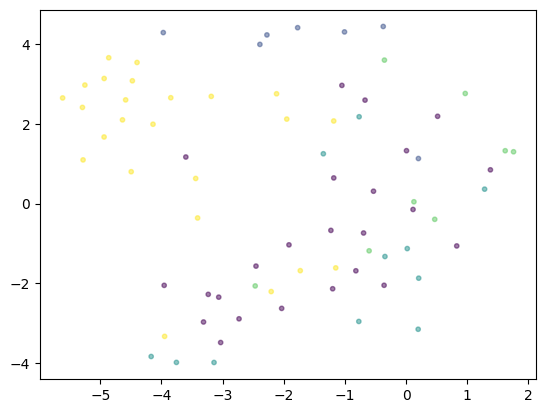

In [ ]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.5 )


In [ ]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=m_len, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 5
    for label in range(5):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [ ]:
int_to_label={
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [ ]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    
print(predict(train_dataset[10]['anchor']))   
    
print(int_to_label[train_dataset[10]['label']])

unordered collections
test order dependency


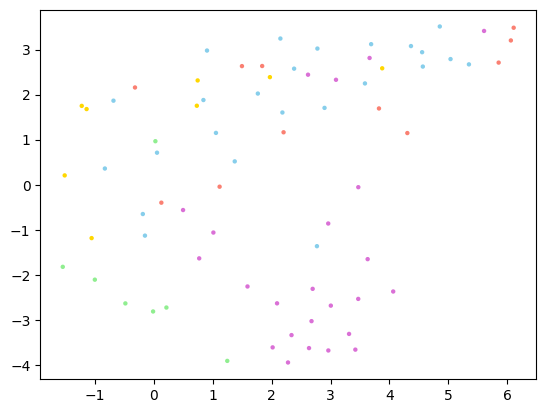

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# previous best result learing rate: 1e-5
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Scatter plot
for i, label in enumerate(labelsNums[:len(X_embedded)]):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
# legend_labels = list(shortened_labels.values())  # Use shortened labels for legend
# plt.legend(labels=legend_labels)

plt.show()


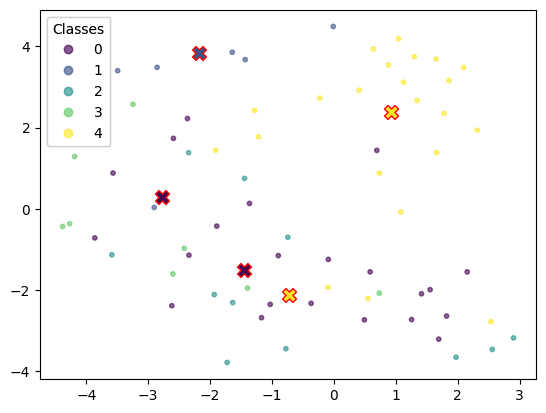

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [ ]:
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# # Assuming 'X_embedded' is your t-SNE result and 'labelsNums' are your labels

# # Silhouette Score:
# # - Measures how similar an object is to its own cluster compared to other clusters.
# # - Range: -1 (incorrect clustering) to 1 (highly dense clustering). 
# #   A score close to 1 means that the clusters are well separated and clearly defined.
# silhouette_avg = silhouette_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Silhouette Score: {silhouette_avg}")

# # Davies-Bouldin Index:
# # - Evaluates the clustering quality by measuring the average 'similarity' between each cluster 
# #   and its most similar one. The similarity is based on a ratio of within-cluster distances to between-cluster distances.
# # - Range: 0 to +∞. Lower scores indicate better clustering quality.
# davies_bouldin = davies_bouldin_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Davies-Bouldin Index: {davies_bouldin}")

# # Calinski-Harabasz Index:
# # - Measures the cluster validity based on the ratio between the within-cluster dispersion and the between-cluster dispersion.
# # - Range: Higher values indicate better clustering quality, with no upper limit. Low values indicate clusters with high overlap.
# calinski_harabasz = calinski_harabasz_score(X_embedded, labelsNums[:len(X_embedded)])
# print(f"Calinski-Harabasz Index: {calinski_harabasz}")


In [ ]:
    from sklearn.metrics import f1_score

    int_to_label={
        0: 'async wait',
        1: 'unordered collections',
        2: 'concurrency',
        3: 'time',
        4: 'test order dependency'
    }
    count = 0

    # Assuming val_dataset is iterable and has 'anchor' and 'label' keys
    predicted_labels = []
    true_labels = []

    for item in val_dataset:
        count+=1
        input_vector = item['anchor']  # Your input vector for prediction
        predicted_label = predict(input_vector)  # Get predicted cluster/label
        predicted_labels.append(predicted_label)
        
        true_label = item['label']  # True label
        true_label = int_to_label[int(true_label)]
        true_labels.append(true_label)
        print(count, " ",predicted_label, " " ,true_label)
    # Convert predicted labels to the same format as true_labels if necessary
    # This might include converting cluster IDs to the label format, depending on how your `predict` function outputs the prediction

    # Note: Ensure that your predict function returns labels in a format that matches true_labels or adjust accordingly
    print("loop completed")
    # Calculate F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Adjust 'average' as necessary
    print(f"F1 Score: {f1}")


1   test order dependency   test order dependency
2   unordered collections   unordered collections
3   time   time
4   time   async wait
5   test order dependency   test order dependency
6   test order dependency   async wait
7   time   unordered collections
8   concurrency   concurrency
9   unordered collections   time
10   async wait   concurrency
11   time   async wait
12   concurrency   test order dependency
13   concurrency   concurrency
14   unordered collections   unordered collections
15   async wait   async wait
16   concurrency   async wait
17   async wait   test order dependency
18   time   concurrency
19   time   time
20   concurrency   async wait
21   test order dependency   test order dependency
22   test order dependency   test order dependency
23   unordered collections   unordered collections
24   test order dependency   test order dependency
25   unordered collections   unordered collections
26   async wait   async wait
27   test order dependency   test order depende

                       precision    recall  f1-score   support

           async wait       0.56      0.21      0.30        24
          concurrency       0.35      0.73      0.47        11
test order dependency       0.90      0.75      0.82        24
                 time       0.33      0.62      0.43         8
unordered collections       0.86      0.86      0.86         7

             accuracy                           0.57        74
            macro avg       0.60      0.63      0.58        74
         weighted avg       0.64      0.57      0.56        74


 - Accuracy :  0.57
 - Precision :  0.64
 - Recall :  0.57
 - F1 score :  0.56
 - MCC :  0.48
 - AUC :  0.74


Perfomnaces by categories



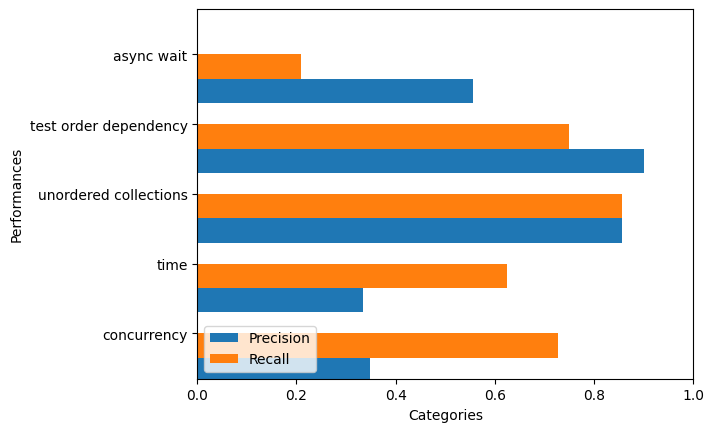



Confusion Matrix 


<AxesSubplot:>

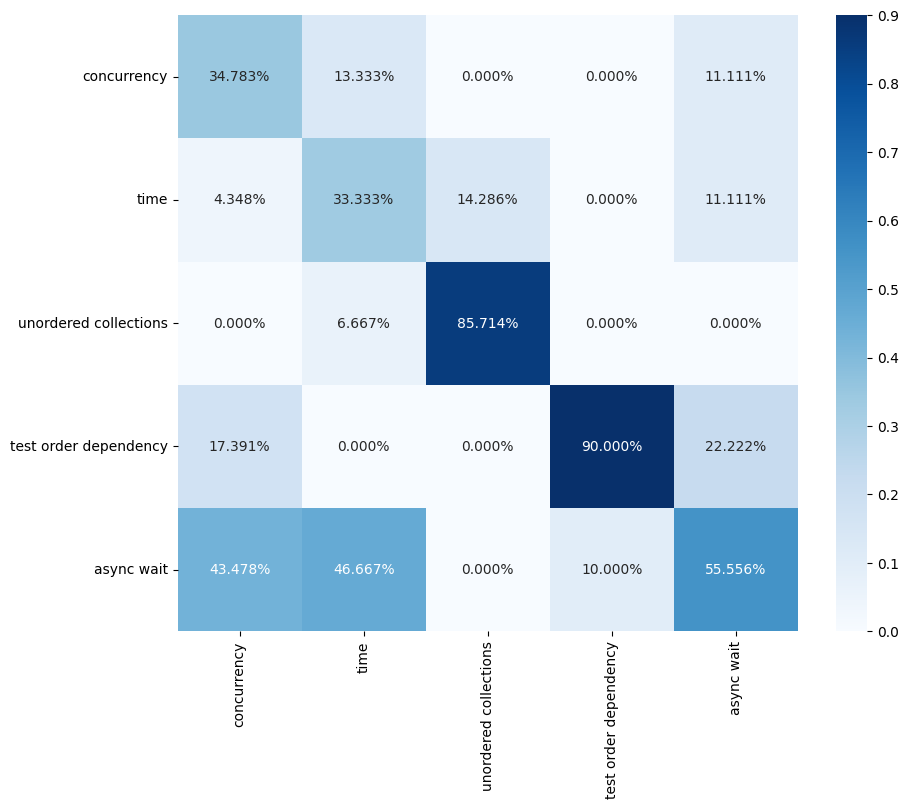

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


predicted = predicted_labels
labels = true_labels
unique_labels = list ( set(labels ) )
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

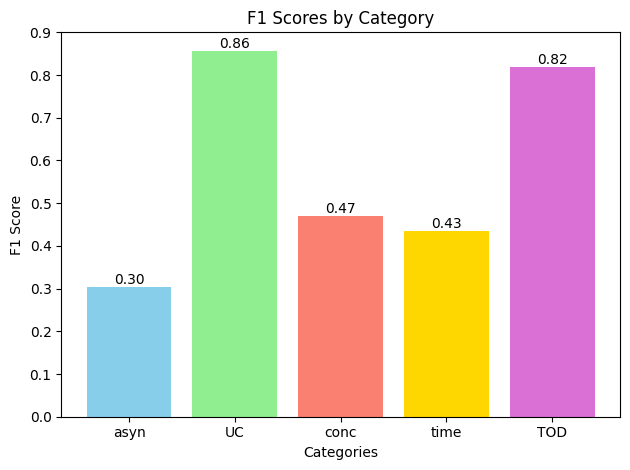

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
int_to_label = {
    0: 'async wait',
    1: 'unordered collections',
    2: 'concurrency',
    3: 'time',
    4: 'test order dependency'
}

# Shortened category names
shortened_labels = {
    'async wait': 'asyn',
    'unordered collections': 'UC',
    'concurrency': 'conc',
    'time': 'time',
    'test order dependency': 'TOD'
}

# Convert true and predicted labels back to integers for F1 score calculation
true_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in true_labels]
predicted_labels_int = [list(int_to_label.keys())[list(int_to_label.values()).index(label)] for label in predicted_labels]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.values())
for category in categories:
    true_bin = [1 if label == category else 0 for label in true_labels]
    pred_bin = [1 if label == category else 0 for label in predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[category] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# file_path = 'test_data_predictions.csv'

# # Load the compressed CSV file into a DataFrame
# df = pd.read_csv(file_path)

# # Extract the 'TrueLabel' and 'PredictedLabel' columns into separate variables
# labels_flaky = df['TrueLabel'].tolist()
# predicted_flaky = df['PredictedLabel'].tolist()

# print (classification_report(labels, predicted))

# print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels_flaky,  predicted_flaky) , 2))
# print(' - Precision : ' , np.round( metrics.precision_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - Recall : ' , np.round( metrics.recall_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - F1 score : ' , np.round( metrics.f1_score(labels_flaky,  predicted_flaky , average='weighted') , 2))
# print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels_flaky,  predicted_flaky) , 2))
# print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels_flaky,  predicted_flaky),2) )

# print("\n\nPerfomnaces by categories\n")


# ind = np.arange(len(unique_labels)) 
# width = 0.35
# fig, ax = plt.subplots()
# precision = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[0]
# recall = metrics.precision_recall_fscore_support(labels_flaky,  predicted_flaky ,  labels=unique_labels )[1]
# ax.barh(ind - width/2, precision, width, label='Precision')
# ax.barh(ind + width/2, recall, width, label='Recall')
# ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
# ylim=[2*width - 1, len(ind)])
# plt.xlim(0,1)
# ax.legend(loc='upper right')
# ax.set_xlabel("Performances")
# ax.set_ylabel("Categories")
# plt.show()

# print("\n\nConfusion Matrix ")

# mat = confusion_matrix(labels_flaky,  predicted_flaky, labels=unique_labels)
# df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
# plt.figure(figsize = (10,8))
# sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# precision_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[0]
# recall_our_model = metrics.precision_recall_fscore_support(labels, predicted, labels=unique_labels)[1]
# # And assuming 'unique_labels' is defined as before

# ind = np.arange(len(unique_labels))  # the x locations for the groups
# width = 0.2  # the width of the bars

# fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figure size as needed

# # Using a set of contrasting, darker colors
# colors = ['blue', 'green', 'red', 'orange']

# # Plotting Precision and Recall for Your Model
# rects1 = ax.bar(ind - width*1.5, precision_our_model, width, label='Our Precision', color=colors[0])
# rects2 = ax.bar(ind - width/2, recall_our_model, width, label='Our Recall', color=colors[1])

# # Plotting Precision and Recall for Flaky Model
# rects3 = ax.bar(ind + width/2, precision_flaky, width, label='FlakyCat Precision', color=colors[2])
# rects4 = ax.bar(ind + width*1.5, recall_flaky, width, label='FlakyCat Recall', color=colors[3])

# # Add some text for labels, title, and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Class-wise Precision and Recall for Our Model vs. FlakyCat Model')
# ax.set_xticks(ind)
# ax.set_xticklabels(unique_labels, rotation=45, ha="right")  # Rotate for better label visibility
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Place the legend outside the figure

# # Optional: Adding scores above bars
# ax.bar_label(rects1, padding=3, fmt='%.2f')
# ax.bar_label(rects2, padding=3, fmt='%.2f')
# ax.bar_label(rects3, padding=3, fmt='%.2f')
# ax.bar_label(rects4, padding=3, fmt='%.2f')

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect to make space for the legend outside

# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming metrics have been calculated and stored in variables for both models.
# # Example metric variables: accuracy, precision, recall, f1_score, mcc, auc for the original model
# # And similarly named variables with a '_flaky' suffix for the comparison model.

# metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'MCC', 'AUC']
# your_model_metrics = [
#     np.round(metrics.accuracy_score(labels, predicted), 2),
#     np.round(metrics.precision_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.recall_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.f1_score(labels, predicted, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels, predicted), 2),
#     np.round(multiclass_roc_auc_score(labels, predicted), 2)
# ]

# flaky_model_metrics = [
#     np.round(metrics.accuracy_score(labels_flaky, predicted_flaky), 2),
#     np.round(metrics.precision_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.recall_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.f1_score(labels_flaky, predicted_flaky, average='weighted'), 2),
#     np.round(metrics.matthews_corrcoef(labels_flaky, predicted_flaky), 2),
#     np.round(multiclass_roc_auc_score(labels_flaky, predicted_flaky), 2)
# ]

# x = np.arange(len(metrics_labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, your_model_metrics, width, label='Our Model')
# rects2 = ax.bar(x + width/2, flaky_model_metrics, width, label='FlakyCat Model')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Metrics Comparison between Our Model and FlakyCat Model')
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()


In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score
# def extract_projections(siamese_network, dataloader):
#     projections = []
#     labels = []
#     for batch in dataloader:
#         label = batch["label"]
#         anchor = batch["anchor"]
#         projection = siamese_network(anchor)
        
#         projections.append(projection.cpu().detach().numpy())
#         labels.append(label.numpy())
#     projections = np.vstack(projections)
#     labels = np.hstack(labels)
#     return projections, labels

In [ ]:
# projections, labels = extract_projections(siamese_network, train_dataloader)
# val_projections, val_labels = extract_projections(siamese_network, val_dataloader)

In [ ]:
# print(len(projections), len(train_dataloader))

In [ ]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_classifier.fit(projections, labels)

# # Train SVM Classifier
# svm_classifier = SVC(kernel='linear', random_state=42)
# svm_classifier.fit(projections, labels)

In [ ]:
# # Evaluate Random Forest Classifier
# rf_predictions = rf_classifier.predict(val_projections)
# rf_accuracy = accuracy_score(val_labels, rf_predictions)
# rf_f1 = f1_score(val_labels, rf_predictions, average='weighted')
# print(f"Random Forest Classifier Accuracy: {rf_accuracy}, F1: {rf_f1}")

# # Evaluate SVM Classifier
# svm_predictions = svm_classifier.predict(val_projections)
# svm_accuracy = accuracy_score(val_labels, svm_predictions)
# svm_f1 = f1_score(val_labels, svm_predictions, average='weighted')
# print(f"SVM Classifier Accuracy: {svm_accuracy}, F1:{svm_f1}")